In [47]:
# matplotlib 한글 깨짐 문제 해결용 (윈도우)
!pip install koreanize-matplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

In [49]:
import koreanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model

In [ ]:
# matplotlib 한글 깨짐 문제 해결용 (윈도우)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
plt.rc('font', family='NanumBarunGothic')

In [38]:
# matplotlib 한글 깨짐 문제 해결용 (맥)
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [5]:
# 시드 배치
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [ ]:
# 데이터 전처리 및 모뎅 생성 시 사용하는 변수
img_size = (224, 224)
input_shape = img_size + (3,)
num_classes = 40
batch_size = 32

In [9]:
# 훈련, 검증, 테스트 데이터 세트 분할
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/콩',
    validation_split=0.2,
    label_mode="categorical",
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/콩',
    validation_split=0.1,
    shuffle=False,
    label_mode="categorical",
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/콩',
    validation_split=0.1,
    shuffle=False,
    label_mode="categorical",
    subset="validation",
    seed=1337,
    image_size=img_size,
    batch_size=batch_size)

Found 1524 files belonging to 2 classes.
Using 1220 files for training.
Found 1524 files belonging to 2 classes.
Using 152 files for validation.
Found 1524 files belonging to 2 classes.
Using 152 files for validation.


Found 1524 files belonging to 2 classes.


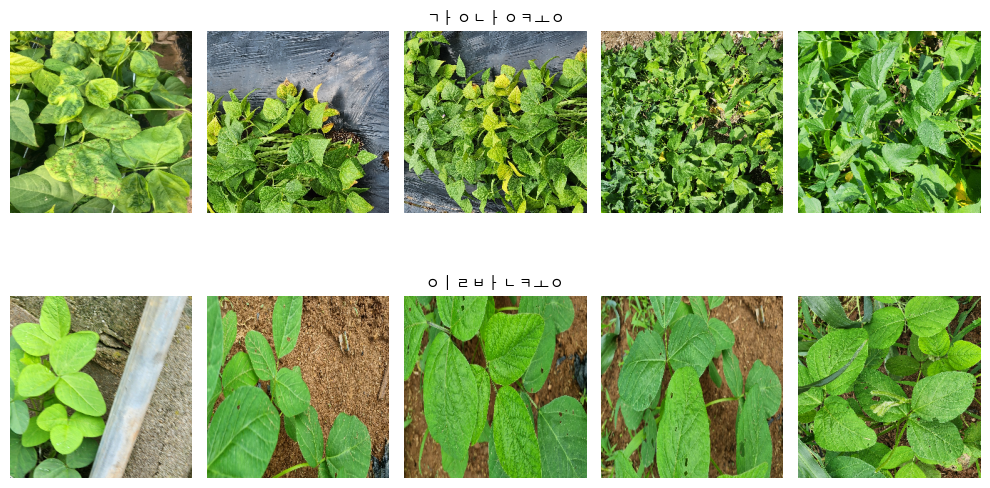

In [50]:
data_temp = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/콩',
    batch_size=5,
    shuffle=False,
    seed=123,
)

class_names = data_temp.class_names

class_names

fig, axes = plt.subplots(2, 5, figsize=(10,6))
axes = axes.flatten()

for i, cls in enumerate(class_names):
    j = 0
    for img, label in data_temp:
        if label[0] == i:
            ax = axes[i*5 + j]
            ax.imshow(img[0].numpy().astype("uint8"))
            ax.axis('off')
            if j == 2:  # middle image
                ax.set_title(cls)  # set title for the middle image
            j += 1
            if j == 5:
                break

plt.tight_layout()
plt.show()

In [11]:
y_test_true = np.concatenate([y for x, y in test_ds], axis=0)
y_test_true = np.argmax(y_test_true, axis=-1)

In [15]:
inputs = tf.keras.Input(shape=input_shape)
x = tf.keras.layers.Lambda(preprocess_input)(inputs)

resnet_model = ResNet50(weights='imagenet',
                        include_top=False,
                        input_shape=input_shape,
                        input_tensor=x)

for layer in resnet_model.layers:
    layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(resnet_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=predictions)

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])
checkpoint_path = "models/best_resnet.h5"
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

In [17]:
history = model.fit(train_ds, validation_data=val_ds, epochs=25, callbacks=[model_checkpoint, early_stopping])

Epoch 1/25
39/39 [==============================] - ETA: 0s - loss: 0.8376 - accuracy: 0.7426
Epoch 1: val_accuracy improved from -inf to 0.82237, saving model to models/best_resnet.h5
39/39 [==============================] - 222s 5s/step - loss: 0.8376 - accuracy: 0.7426 - val_loss: 0.3851 - val_accuracy: 0.8224
Epoch 2/25
39/39 [==============================] - ETA: 0s - loss: 0.2505 - accuracy: 0.9008
Epoch 2: val_accuracy did not improve from 0.82237
39/39 [==============================] - 242s 6s/step - loss: 0.2505 - accuracy: 0.9008 - val_loss: 0.4060 - val_accuracy: 0.8224
Epoch 3/25
39/39 [==============================] - ETA: 0s - loss: 0.1941 - accuracy: 0.9221
Epoch 3: val_accuracy improved from 0.82237 to 0.86184, saving model to models/best_resnet.h5
39/39 [==============================] - 203s 5s/step - loss: 0.1941 - accuracy: 0.9221 - val_loss: 0.3095 - val_accuracy: 0.8618
Epoch 4/25
39/39 [==============================] - ETA: 0s - loss: 0.1458 - accuracy: 0.943

In [24]:
model.save('/content/drive/MyDrive/model')

In [27]:
final_model = tf.keras.models.load_model("/content/drive/MyDrive/model")
hist_df = pd.DataFrame(history.history)
hist_df.to_csv("/content/drive/MyDrive/history/history_resnet.csv", index=False)
history_df = pd.read_csv("/content/drive/MyDrive/history/history_resnet.csv")

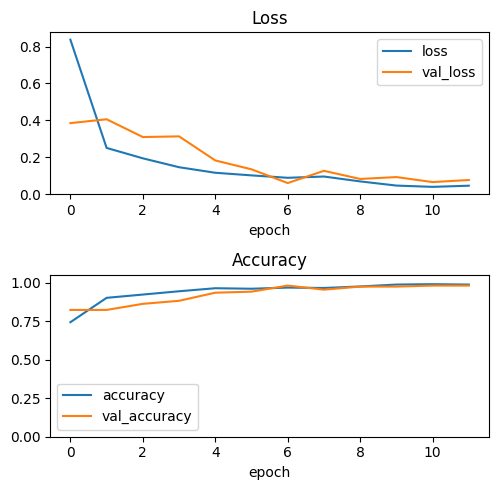

In [28]:
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(211)
ax1.set_title('Loss')
ax1.plot(history_df['loss'], label='loss')
ax1.plot(history_df['val_loss'], label='val_loss')
ax1.set_xlabel("epoch")
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.set_title('Accuracy')
ax2.plot(history_df['accuracy'], label='accuracy')
ax2.plot(history_df['val_accuracy'], label='val_accuracy')
ax2.set_xlabel("epoch")
ax2.legend()
ax2.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

In [32]:
y_test_pred = np.argmax(final_model.predict(test_ds), axis=-1)

5/5 [==============================] - 22s 4s/step


In [33]:
def format_percent(val):
    return "{:.2f}%".format(val * 100)


In [34]:
report = classification_report(y_test_true, y_test_pred, digits=4, output_dict=True)
class_report = pd.DataFrame(report).transpose()
class_report.iloc[:, :3] = class_report.iloc[:, :3].applymap(lambda x: x * 100)
class_report = class_report.style.format("{:.2f}", subset=pd.IndexSlice[:, ['precision', 'recall', 'f1-score']])\
                              .format("{:.0f}", subset=pd.IndexSlice[:, ['support']])
class_report

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.00,0.00,0.00,0
1,100.00,98.03,99.00,152
accuracy,98.03,98.03,98.03,1
macro avg,50.00,49.01,49.50,152
weighted avg,100.00,98.03,99.00,152


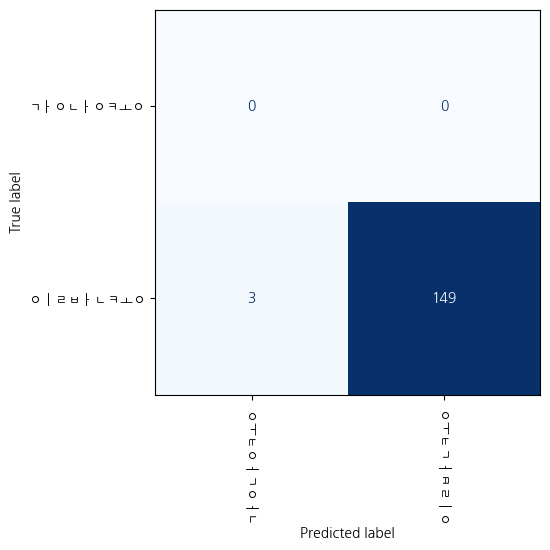

In [51]:
class_names = test_ds.class_names
conf = confusion_matrix(y_test_true, y_test_pred)
disp = ConfusionMatrixDisplay(conf, display_labels=class_names)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=False)
plt.show()
